In [2]:
import os
import yaml
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import FileLink
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Configuration
DATA_PATH = "/kaggle/input/8-facial-expressions-for-yolo/9 Facial Expressions you need"
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.0005
IMG_SIZE = 224
NUM_CLASSES = 9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Emotion labels
emotion_labels = {
    0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear',
    4: 'Happy', 5: 'Natural', 6: 'Sad', 7: 'Sleepy', 8: 'Surprised'
}

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (1 - pt)**self.gamma * ce_loss
        if self.alpha is not None:
            loss = self.alpha[targets] * loss
        return loss.mean()

# Load YAML config
with open(os.path.join(DATA_PATH, 'data.yaml')) as f:
    data_config = yaml.safe_load(f)
print("Classes from YAML:", data_config['names'])

class YoloEmotionDataset(Dataset):
    def __init__(self, base_path, image_paths, label_paths, transform=None):
        self.base_path = base_path
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.image_paths[idx])
        label_path = os.path.join(self.base_path, self.label_paths[idx])
        
        image = Image.open(img_path).convert('RGB')
        
        with open(label_path, 'r') as f:
            lines = f.readlines()
            class_id = int(lines[0].split()[0]) if len(lines) > 0 else 5  # Default to Neutral
        
        if self.transform:
            image = self.transform(image)
            
        return image, class_id

def collect_paths(base_path, mode='train'):
    images_dir = os.path.join(base_path, mode, 'images')
    labels_dir = os.path.join(base_path, mode, 'labels')
    
    return [
        (f"{mode}/images/{img_file}", f"{mode}/labels/{img_file.rsplit('.', 1)[0]}.txt")
        for img_file in os.listdir(images_dir)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg'))
        and os.path.exists(os.path.join(labels_dir, img_file.rsplit('.', 1)[0] + '.txt'))
    ]

# Enhanced augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data collection
train_paths = collect_paths(DATA_PATH, 'train')
val_paths = collect_paths(DATA_PATH, 'valid')

train_image_paths, train_label_paths = zip(*train_paths) if train_paths else ([], [])
val_image_paths, val_label_paths = zip(*val_paths) if val_paths else ([], [])

print(f"Found {len(train_image_paths)} training images")
print(f"Found {len(val_image_paths)} validation images")

train_dataset = YoloEmotionDataset(DATA_PATH, train_image_paths, train_label_paths, train_transform)
val_dataset = YoloEmotionDataset(DATA_PATH, val_image_paths, val_label_paths, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

def initialize_model(model_name='efficientnet_b0'):
    if model_name == 'resnet50':
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
        )
    elif model_name == 'vit':
        model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        model.heads.head = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
        )
    elif model_name == 'efficientnet_b0':
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
        )
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    
    return model.to(device)

model = initialize_model('efficientnet_b0')

# Calculate class weights
class_counts = np.zeros(NUM_CLASSES)
for _, label in train_dataset:
    class_counts[label] += 1
class_weights = 1. / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = FocalLoss(alpha=class_weights, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    if len(np.unique(all_labels)) > 1:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=emotion_labels.values()))
    
    return total_loss / len(loader), 100 * correct / total

# Training with logging
best_val_acc = 0
patience = 5
no_improve = 0
lr_history = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.2e}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

# Testing
test_paths = collect_paths(DATA_PATH, 'test')
if test_paths:
    test_image_paths, test_label_paths = zip(*test_paths)
    test_dataset = YoloEmotionDataset(DATA_PATH, test_image_paths, test_label_paths, val_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    test_loss, test_acc = validate(model, test_loader, criterion)
    print(f"\nTest Accuracy: {test_acc:.2f}%")

FileLink('/kaggle/working/best_model.pth')

Classes from YAML: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'natural', 'sad', 'sleepy', 'surprised']


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Found 64864 training images
Found 1720 validation images


100%|██████████| 20.5M/20.5M [00:00<00:00, 215MB/s]



Classification Report:
              precision    recall  f1-score   support

       Angry       0.77      0.50      0.61       258
    Contempt       0.46      0.80      0.58        82
     Disgust       0.46      0.73      0.57       108
        Fear       0.57      0.83      0.67       107
       Happy       0.89      0.79      0.83       387
     Natural       0.58      0.57      0.58       172
         Sad       0.70      0.62      0.66       312
      Sleepy       0.63      0.87      0.73        38
   Surprised       0.78      0.74      0.76       256

    accuracy                           0.69      1720
   macro avg       0.65      0.72      0.67      1720
weighted avg       0.72      0.69      0.69      1720

Epoch 1/30: Train Loss: 0.0451, Acc: 53.60% | Val Loss: 0.0283, Acc: 68.72% | LR: 5.00e-04

Classification Report:
              precision    recall  f1-score   support

       Angry       0.82      0.53      0.65       258
    Contempt       0.40      0.82      0.54    

/kaggle/working/best_model.pth

In [5]:
from IPython.display import FileLink

# Compress the model into a ZIP file
os.system("zip -r model.zip /kaggle/working/")

# Create a download link
FileLink("model.zip")

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/best_model.pth (deflated 8%)


/kaggle/working/model.zip


Classification Report:
              precision    recall  f1-score   support

       angry       0.86      0.81      0.83       297
    contempt       0.63      0.74      0.68        68
     disgust       0.70      0.78      0.73        98
        fear       0.83      0.83      0.83       144
       happy       0.95      0.94      0.94       407
     natural       0.64      0.71      0.68       136
         sad       0.85      0.75      0.80       298
      sleepy       0.97      1.00      0.99        33
   surprised       0.84      0.89      0.87       219

    accuracy                           0.83      1700
   macro avg       0.81      0.83      0.82      1700
weighted avg       0.84      0.83      0.84      1700



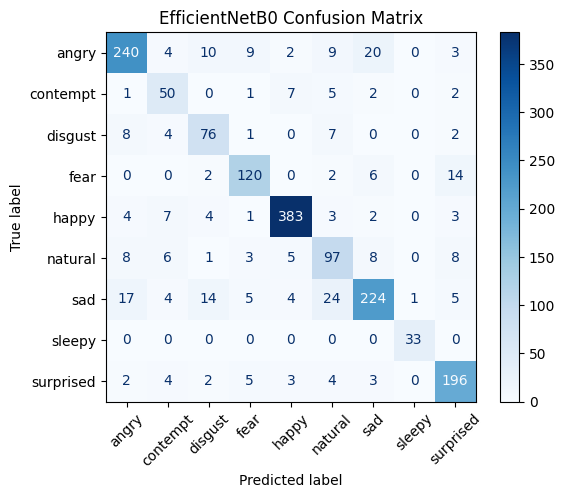

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
class_names =  ['angry', 'contempt', 'disgust', 'fear', 'happy', 'natural', 'sad', 'sleepy', 'surprised']

# ---- Evaluation: Generate predictions ----
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---- Classification Report ----
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("EfficientNetB0 Confusion Matrix")
plt.show()
